Any kind of change we apply on our model has some regularization effect, like adding data transforms, tweaking hyperparameters, dropout rate, etc. If we are using a combination of these and we decide to add one more transform or any other technique, we must reduce the amplitude of the already present techniques s.

Since we have applied multiple transformations on our train data, it is better to reduce some other values like dropout. In previous codes, dropout value was 0.1. In this model, it has been reduced to 0.07.

As a result, we can see some improvement in the test accuracy and the mode reaches consistently achieves >99.4% accuracy in the last few epochs.

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
!pip install torchsummary

## Model

In [ ]:
dropout_value = 0.07

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0), # receptive field = 3
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0), # rf = 5
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        # transition block 1
        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1), 
            nn.MaxPool2d(2, 2), # rf = 10
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        # end

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0), # rf = 12
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding = 0), # rf = 30
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        # # 1x1 conv
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1), # rf = 30
        #     nn.BatchNorm2d(8),
        #     nn.Dropout(dropout_value),
        #     nn.ReLU()
        # )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 0), # rf = 32
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 1), # rf = 32
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size = 6)
        )

        # final FC layer (read fully convolutional, not fully connected)
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=1),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1)
        )

        self.dropout = nn.Dropout(dropout_value)
    
    def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv_1_1(x)
            x = self.conv3(x)
            x = self.conv4(x)
            # x = self.conv5(x)
            x = self.conv6(x)
            x = self.conv7(x)
            x = self.gap(x)
            x = self.conv8(x)
            x = self.conv9(x)

            x = x.view(-1, 10)
            return F.log_softmax(x)


## Model Summary

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,820
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             210
        MaxPool2d-10           [-1, 10, 12, 12]               0
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Data loading and transformations

In [ ]:
torch.manual_seed(1) # for consistent output
batch_size = 64

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # augmentation
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # mean, std of the data
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Train and Test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # setting the gradients to zero after every backprop step
    y_pred = model(data) # predicting the values
    loss = F.nll_loss(y_pred, target) # calculating the loss using negative loss likelihood
    train_losses.append(loss)
    loss.backward() # backpropagation
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    accuracy = 100. * correct / processed

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100. * correct / processed:0.2f}')
    train_acc.append(100. * correct / processed)
    # return accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # since we do not want to compute gradients on the test data, we use torch.no_grad()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing

In [ ]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)

for epoch in range(1, 15):
    print('Epoch:',  epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)
    # scheduler.step(train_acc[epoch-1])

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.3322505056858063 Batch_id=937 Accuracy=90.43: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0757, Accuracy: 9776/10000 (97.76%)

Epoch: 2


Loss=0.13364717364311218 Batch_id=937 Accuracy=96.94: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9864/10000 (98.64%)

Epoch: 3


Loss=0.26543349027633667 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9900/10000 (99.00%)

Epoch: 4


Loss=0.008344665169715881 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

Epoch: 5


Loss=0.05714035406708717 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:38<00:00, 24.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)

Epoch: 6


Loss=0.03693389892578125 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

Epoch: 7


Loss=0.01559226494282484 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:38<00:00, 24.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

Epoch: 8


Loss=0.03448815271258354 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

Epoch: 9


Loss=0.006294816266745329 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

Epoch: 10


Loss=0.050713203847408295 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:38<00:00, 24.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

Epoch: 11


Loss=0.009408030658960342 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:38<00:00, 24.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

Epoch: 12


Loss=0.014743424952030182 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:37<00:00, 24.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

Epoch: 13


Loss=0.2492128610610962 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

Epoch: 14


Loss=0.0555269792675972 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:38<00:00, 24.57it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)



## Plotting

Text(0.5, 1.0, 'Test Accuracy')

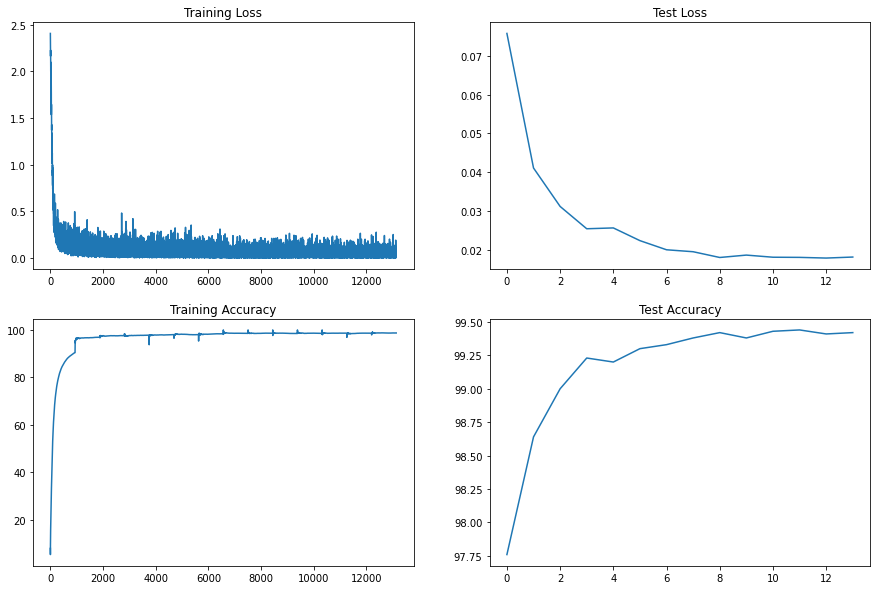

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")